# Pet is Adopted or not predictor

## Imports

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (16, 8)
plt.rc('axes', titlesize=22)
plt.rc('figure', titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

## Data wrangling

In [3]:
url = "https://storage.googleapis.com/cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv"

In [4]:
df = pd.read_csv(url)

In [5]:
df.shape

(11537, 14)

In [6]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes


## Data exploration / Feature engineering

First we separate the target variable from the input features

In [7]:
X, y = df.drop("Adopted", axis=1), df["Adopted"]

Next we split the dataset into training, validation and testing sets.

We are first using a `test_size` of 0.2, which gives 80% training data and 20%
We are next using a `test_size` of 0.25, as 0.25 x 0.8 is 0.2. Meaning, 25% of the training dataset is actually 20% of the original full dataset. Thus giving an 80/20/20 overall split for training/validation/testing.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Target variable

In [9]:
target_dist = y.value_counts(dropna=False)

In [10]:
target_dist

Yes    8457
No     3080
Name: Adopted, dtype: int64

In [11]:
print(f"Adopted value of '{target_dist.index[0]}': {100 * target_dist[0] / (target_dist[0] + target_dist[1]):.2f}%")
print(f"Adopted value of '{target_dist.index[1]}': {100 * target_dist[1] / (target_dist[0] + target_dist[1]):.2f}%")

Adopted value of 'Yes': 73.30%
Adopted value of 'No': 26.70%


#### Function for later use in converting 'Adopted' into a format suited for XGBoost

In [12]:
def clean_target(val: str) -> int:
    return 1 if val == "Yes" else 0

### Input features

In [13]:
X_train.columns

Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt'],
      dtype='object')

In [14]:
X_train.dtypes

Type            object
Age              int64
Breed1          object
Gender          object
Color1          object
Color2          object
MaturitySize    object
FurLength       object
Vaccinated      object
Sterilized      object
Health          object
Fee              int64
PhotoAmt         int64
dtype: object

#### Numeric columns
Numeric columns don't typically require much engineering (unless creating new features, which the task has suggested not to do).

In [15]:
numeric_cols = X_train.select_dtypes(include="int64")

In [16]:
for col in numeric_cols.columns:
    print(numeric_cols[col].value_counts(dropna=False).head(60))

2      1507
3       906
1       864
4       511
12      488
24      340
5       305
6       274
36      204
7       167
8       163
48      121
60      114
9       102
18       86
10       82
84       62
72       56
14       49
11       46
0        41
17       33
15       33
30       31
96       30
13       24
20       20
16       19
29       18
19       16
22       16
120      15
108      12
21       12
41        9
27        9
42        9
54        8
32        7
28        7
50        6
31        6
26        6
23        6
132       5
33        4
38        4
51        4
25        4
39        3
46        3
52        3
62        3
55        2
35        2
61        2
77        2
53        2
34        2
255       2
Name: Age, dtype: int64
0       5742
50       215
100      195
200      127
150       81
20        77
300       66
250       59
80        45
30        40
500       34
1         33
10        33
350       24
400       14
5         12
40        11
120       11
15        10
70       

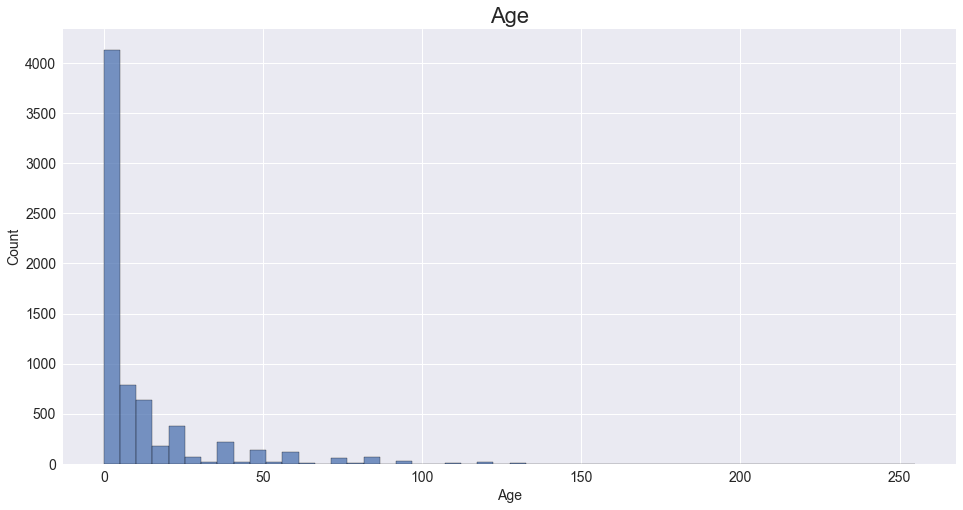

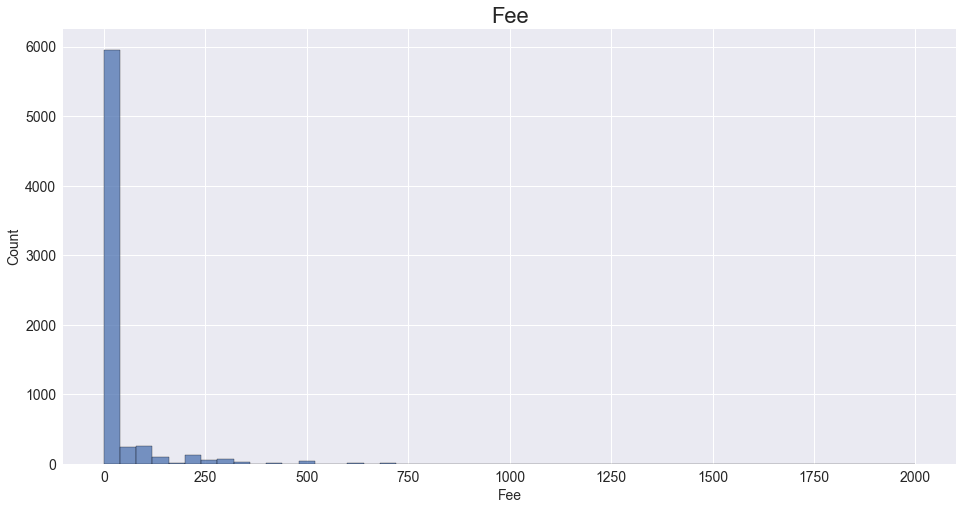

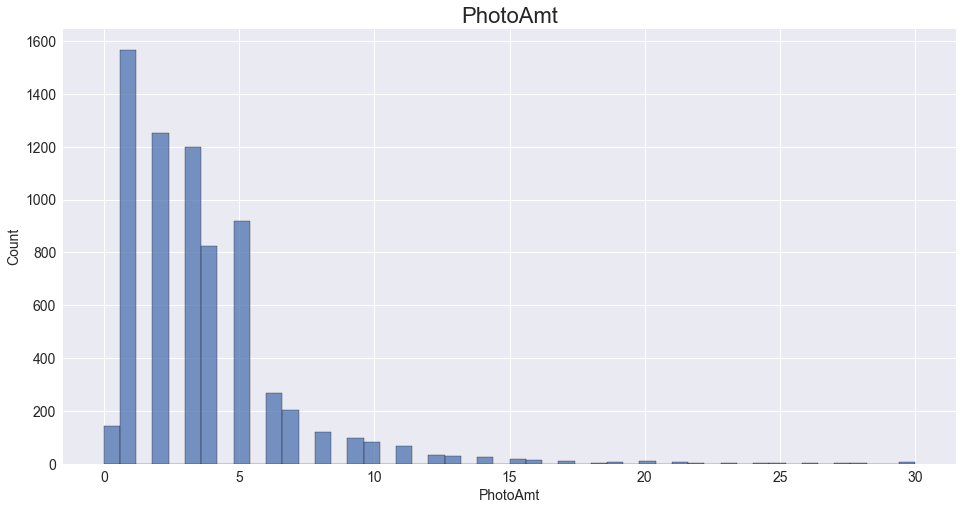

In [17]:
for col in numeric_cols.columns:
    sns.histplot(data=numeric_cols, x=col, bins=50)
    plt.title(col)
    plt.show()

#### Categorical features

In [18]:
categorical_cols = X_train.select_dtypes(include="object")

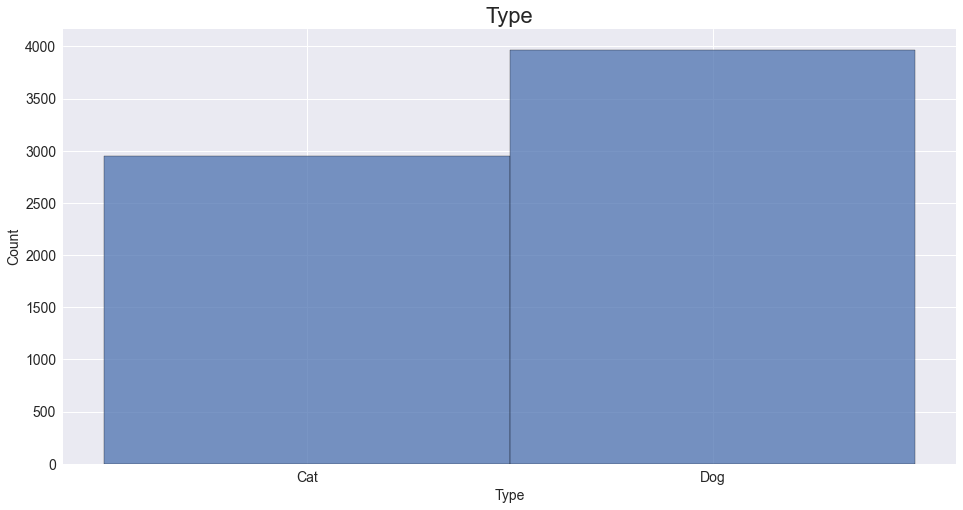

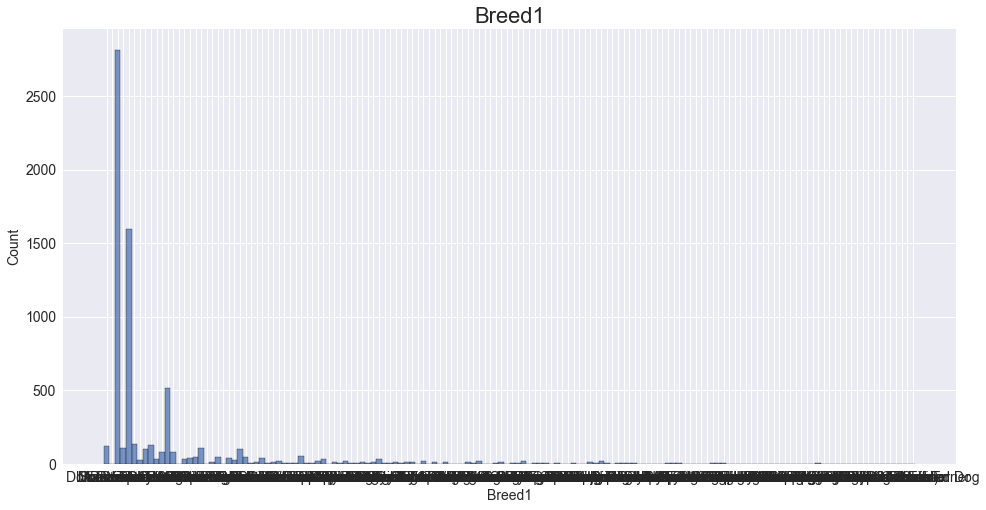

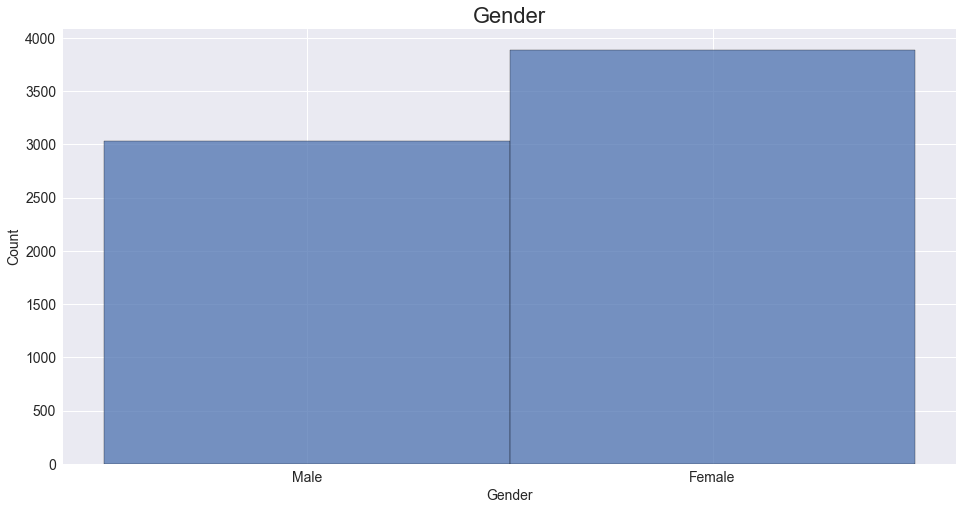

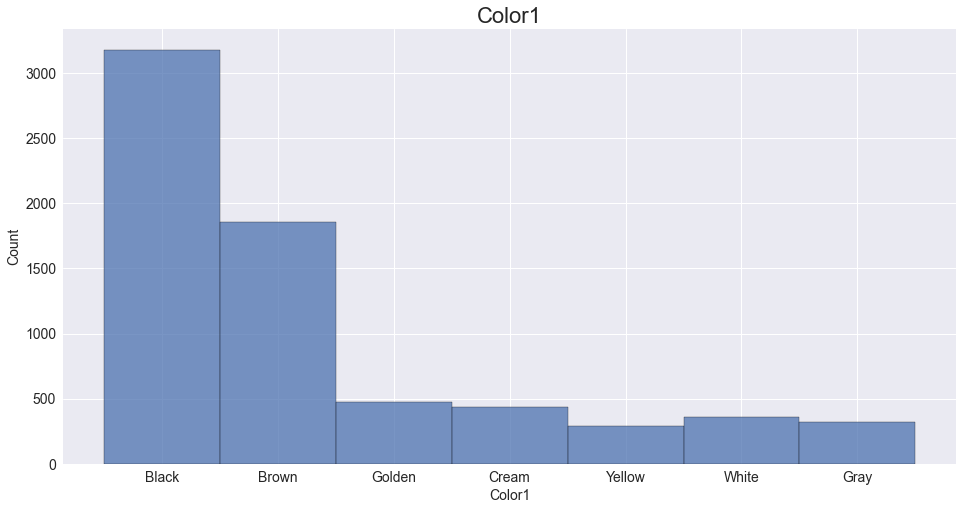

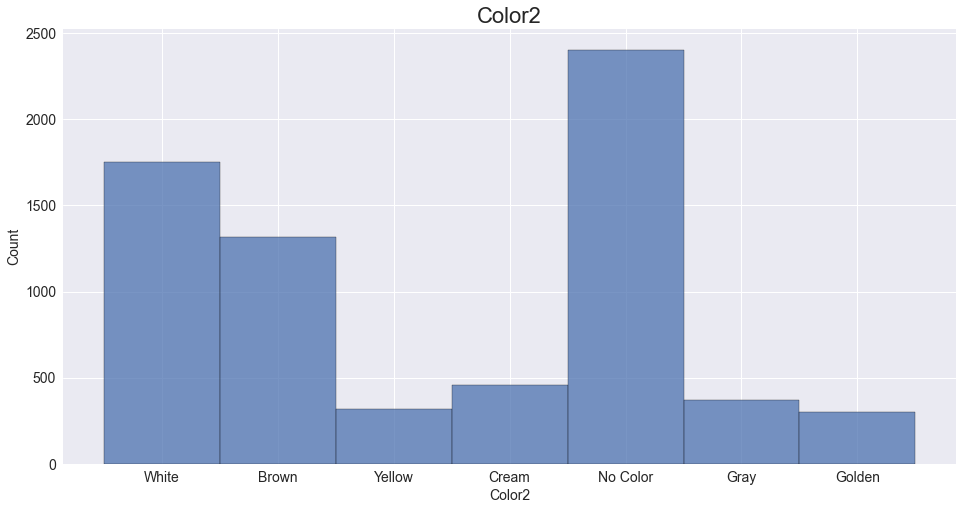

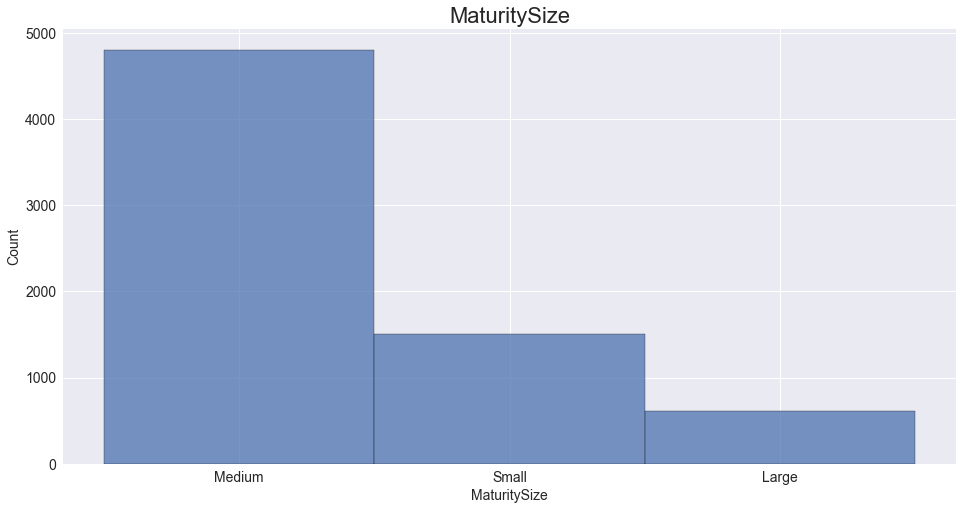

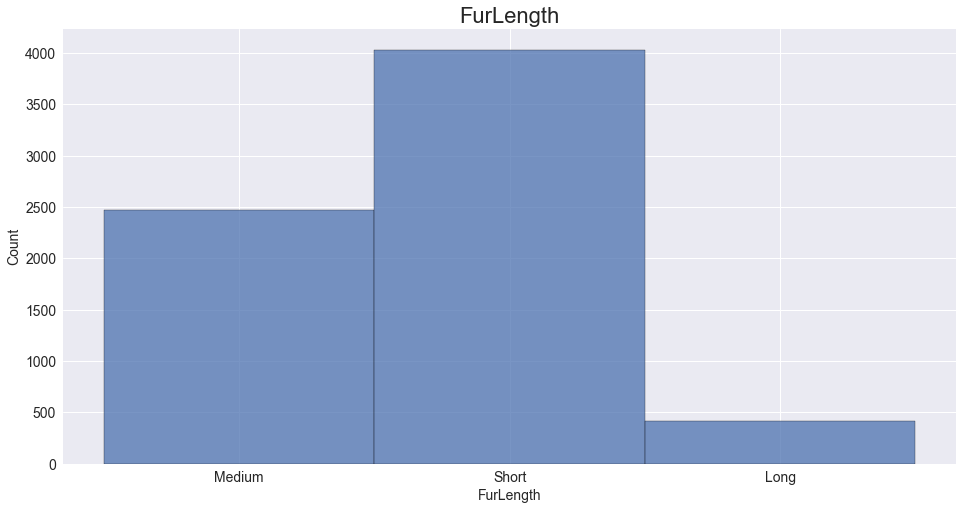

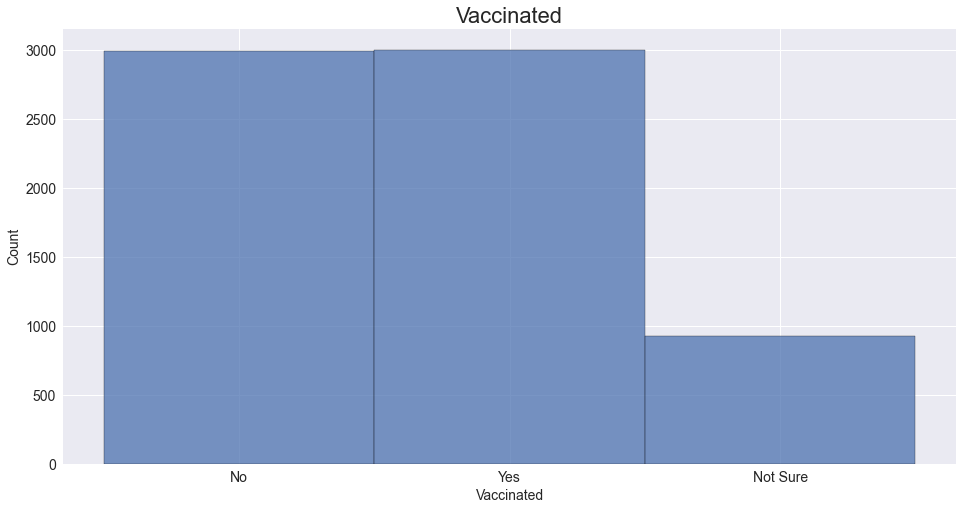

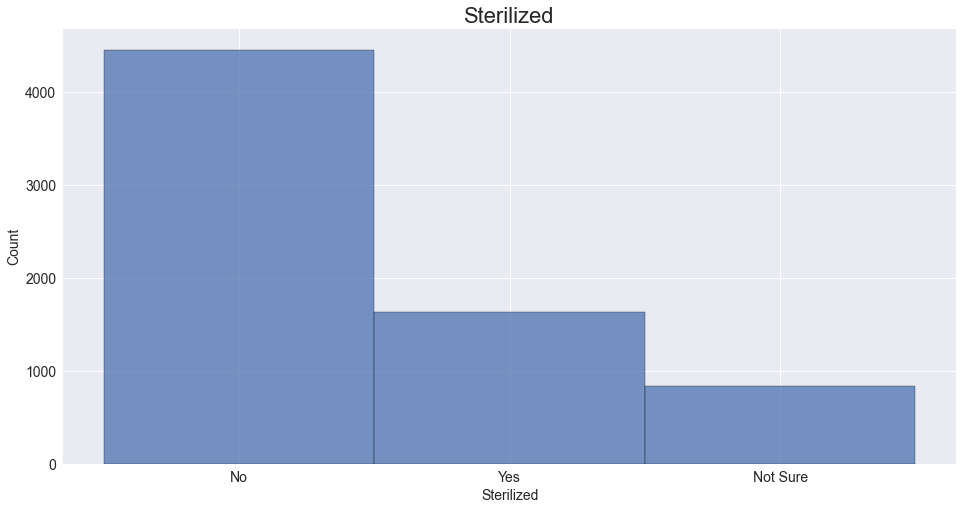

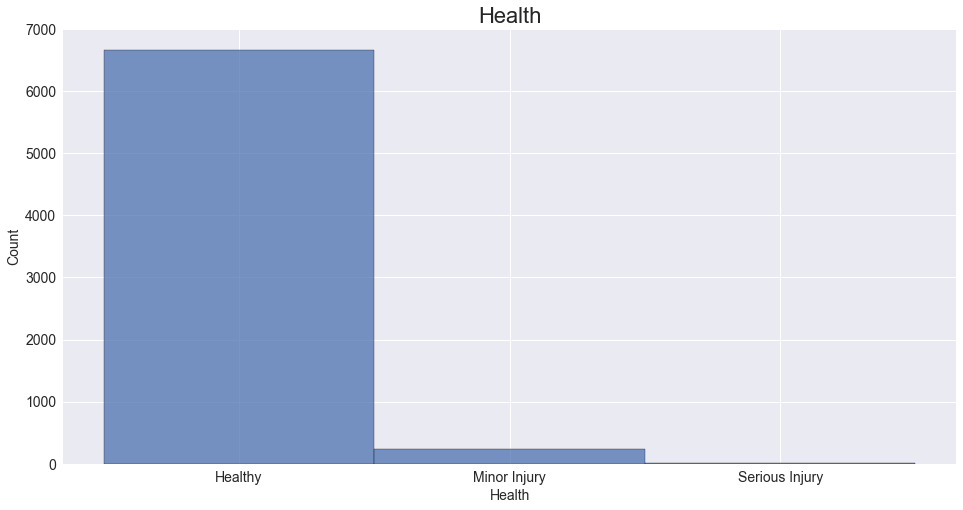

In [19]:
for col in categorical_cols.columns:
    sns.histplot(data=categorical_cols, x=col, bins=50)
    plt.title(col)
    plt.show()

In [20]:
for col in categorical_cols.columns:
    print(X[col].value_counts(dropna=False))

Dog    6601
Cat    4936
Name: Type, dtype: int64
Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
                        ... 
Bedlington Terrier         1
American Bulldog           1
Rhodesian Ridgeback        1
Setter                     1
Dutch Shepherd             1
Name: Breed1, Length: 166, dtype: int64
Female    6466
Male      5071
Name: Gender, dtype: int64
Black     5241
Brown     3075
Golden     789
Cream      765
White      593
Gray       575
Yellow     499
Name: Color1, dtype: int64
No Color    3968
White       2920
Brown       2203
Cream        788
Gray         659
Yellow       535
Golden       464
Name: Color2, dtype: int64
Medium    8016
Small     2480
Large     1041
Name: MaturitySize, dtype: int64
Short     6676
Medium    4152
Long       709
Name: FurLength, dtype: int64
Yes         5060
No          4962
Not Sure    1515
Name: Vaccinated, dtype: int64
No          7497
Yes  

In [21]:
len(X["Breed1"].value_counts(dropna=False))

166

In [22]:
breeds_count = X["Breed1"].value_counts(dropna=False).reset_index()

In [23]:
breeds_count.head(10)

,index,Breed1
0,Mixed Breed,4629
1,Domestic Short Hair,2605
2,Domestic Medium Hair,865
3,Tabby,242
4,Domestic Long Hair,223
5,Siamese,202
6,Shih Tzu,178
7,Persian,177
8,Labrador Retriever,175
9,Poodle,161


In [24]:
breeds_mapping = dict(zip(breeds_count["index"], breeds_count.index))

In [25]:
breeds_mapping

{'Mixed Breed': 0,
 'Domestic Short Hair': 1,
 'Domestic Medium Hair': 2,
 'Tabby': 3,
 'Domestic Long Hair': 4,
 'Siamese': 5,
 'Shih Tzu': 6,
 'Persian': 7,
 'Labrador Retriever': 8,
 'Poodle': 9,
 'Terrier': 10,
 'Golden Retriever': 11,
 'German Shepherd Dog': 12,
 'Beagle': 13,
 'Rottweiler': 14,
 'Spitz': 15,
 'Calico': 16,
 'Schnauzer': 17,
 'American Shorthair': 18,
 'Jack Russell Terrier': 19,
 'Miniature Pinscher': 20,
 'Oriental Short Hair': 21,
 'Bengal': 22,
 'Doberman Pinscher': 23,
 'Tuxedo': 24,
 'Cocker Spaniel': 25,
 'Tortoiseshell': 26,
 'Husky': 27,
 'Dalmatian': 28,
 'Chihuahua': 29,
 'Maine Coon': 30,
 'British Shorthair': 31,
 'Silky Terrier': 32,
 'Dachshund': 33,
 'Belgian Shepherd Malinois': 34,
 'Siberian Husky': 35,
 'Pomeranian': 36,
 'Russian Blue': 37,
 'Border Collie': 38,
 'Pug': 39,
 'Abyssinian': 40,
 'Burmese': 41,
 'Maltese': 42,
 'Pekingese': 43,
 'Pit Bull Terrier': 44,
 'Corgi': 45,
 'Bull Terrier': 46,
 'Bobtail': 47,
 'Tiger': 48,
 'American Cur

In [26]:
class FeatureEngineer:
    def __init__(self):
        pass

    @staticmethod
    def create_binary(series: pd.Series, one_val: str) -> pd.Series:
        return series.apply(lambda val: 1 if val == one_val else 0)

    @staticmethod
    def create_ordinal(series: pd.Series, mapping: dict[str, int]) -> pd.Series:
        return series.apply(lambda val: mapping[val])

    @staticmethod
    def create_one_hot(series: pd.Series, prefix: str = None) -> pd.DataFrame:
        return pd.get_dummies(series, prefix=prefix)

    def process_features(self, features: pd.DataFrame) -> pd.DataFrame:
        df = features.copy()
        df["Type"] = self.create_binary(df["Type"], "Dog")
        df["Breed1"] = self.create_ordinal(df["Breed1"], breeds_mapping)
        df["Gender"] = self.create_binary(df["Gender"], "Male")
        df = df.join(self.create_one_hot(df["Color1"], prefix="Color1")).drop("Color1", axis=1)
        df = df.join(self.create_one_hot(df["Color2"], prefix="Color2")).drop("Color2", axis=1)
        df["MaturitySize"] = self.create_ordinal(df["MaturitySize"], {"Small": 0, "Medium": 1, "Large": 2})
        df["FurLength"] = self.create_ordinal(df["FurLength"], {"Short": 0, "Medium": 1, "Long": 2})
        df["Vaccinated"] = self.create_ordinal(df["Vaccinated"], {"No": -1, "Not Sure": 0, "Yes": 1})
        df["Sterilized"] = self.create_ordinal(df["Sterilized"], {"No": -1, "Not Sure": 0, "Yes": 1})
        df["Health"] = self.create_ordinal(df["Health"], {"Healthy": 0, "Minor Injury": 1, "Serious Injury": 2})
        return df

    def process_target(self, target: pd.Series) -> pd.Series:
        series = target.copy()
        return self.create_binary(series, "Yes")

In [27]:
fe = FeatureEngineer()

In [28]:
fe.process_features(X_train).head()

,Type,Age,Breed1,Gender,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,...,Color1_Gray,Color1_White,Color1_Yellow,Color2_Brown,Color2_Cream,Color2_Golden,Color2_Gray,Color2_No Color,Color2_White,Color2_Yellow
9207,0,12,5,1,1,1,-1,-1,0,250,...,0,0,0,0,0,0,0,0,1,0
10399,1,18,115,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
213,1,1,0,0,1,0,1,-1,0,0,...,0,0,0,1,0,0,0,0,0,0
6931,0,7,7,0,0,2,1,-1,1,0,...,0,0,0,0,0,0,0,0,0,1
6802,0,1,1,1,1,0,-1,-1,0,50,...,0,0,0,0,0,0,0,0,1,0


In [29]:
xgb = XGBClassifier(use_label_encoder=False)

In [30]:
X_train = fe.process_features(X_train)
X_val = fe.process_features(X_val)
X_test = fe.process_features(X_test)

y_train = fe.process_target(y_train)
y_val = fe.process_target(y_val)
y_test = fe.process_target(y_test)

In [31]:
model = xgb.fit(X_train, y_train,
                eval_metric="logloss",
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20
                )

[0]	validation_0-logloss:0.60563
[1]	validation_0-logloss:0.55780
[2]	validation_0-logloss:0.53004
[3]	validation_0-logloss:0.51128
[4]	validation_0-logloss:0.50005
[5]	validation_0-logloss:0.49348
[6]	validation_0-logloss:0.48731
[7]	validation_0-logloss:0.48322
[8]	validation_0-logloss:0.48226
[9]	validation_0-logloss:0.48218
[10]	validation_0-logloss:0.48035
[11]	validation_0-logloss:0.47862
[12]	validation_0-logloss:0.47767
[13]	validation_0-logloss:0.47697
[14]	validation_0-logloss:0.47547
[15]	validation_0-logloss:0.47631
[16]	validation_0-logloss:0.47722
[17]	validation_0-logloss:0.47729
[18]	validation_0-logloss:0.47706
[19]	validation_0-logloss:0.47681
[20]	validation_0-logloss:0.47735
[21]	validation_0-logloss:0.47794
[22]	validation_0-logloss:0.47946
[23]	validation_0-logloss:0.47971
[24]	validation_0-logloss:0.47994
[25]	validation_0-logloss:0.48119
[26]	validation_0-logloss:0.48146
[27]	validation_0-logloss:0.48189
[28]	validation_0-logloss:0.48186
[29]	validation_0-loglos

In [32]:
model.get_booster().best_iteration

14

In [33]:
xgb = XGBClassifier(use_label_encoder=False,
                    n_estimators=model.get_booster().best_iteration)
model = xgb.fit(X_train, y_train, eval_metric="logloss"
                )

In [34]:
print(f"F1 Score on the test set: {f1_score(model.predict(X_test), y_test):.4f}")

F1 Score on the test set: 0.8456


In [35]:
print(f"Accuracy Score on the test set: {accuracy_score(model.predict(X_test), y_test):.4f}")

Accuracy Score on the test set: 0.7574


In [36]:
print(f"Recall Score on the test set: {recall_score(model.predict(X_test), y_test):.4f}")

Recall Score on the test set: 0.7815


In [37]:
cm = confusion_matrix(y_test, model.predict(X_test))

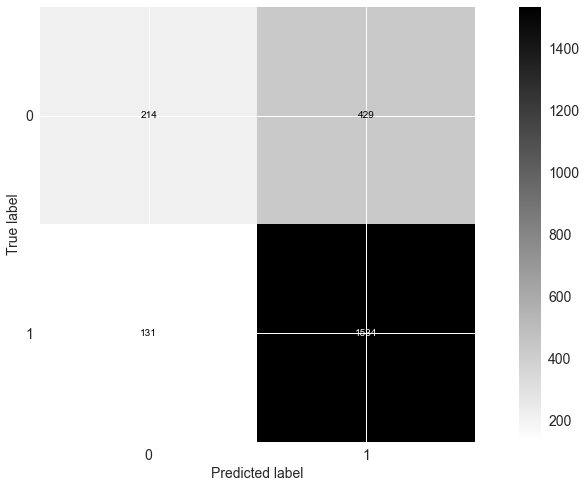

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="binary")
plt.show()